:weißes_häkchen: Daten geladen: 4422469 Zeilen


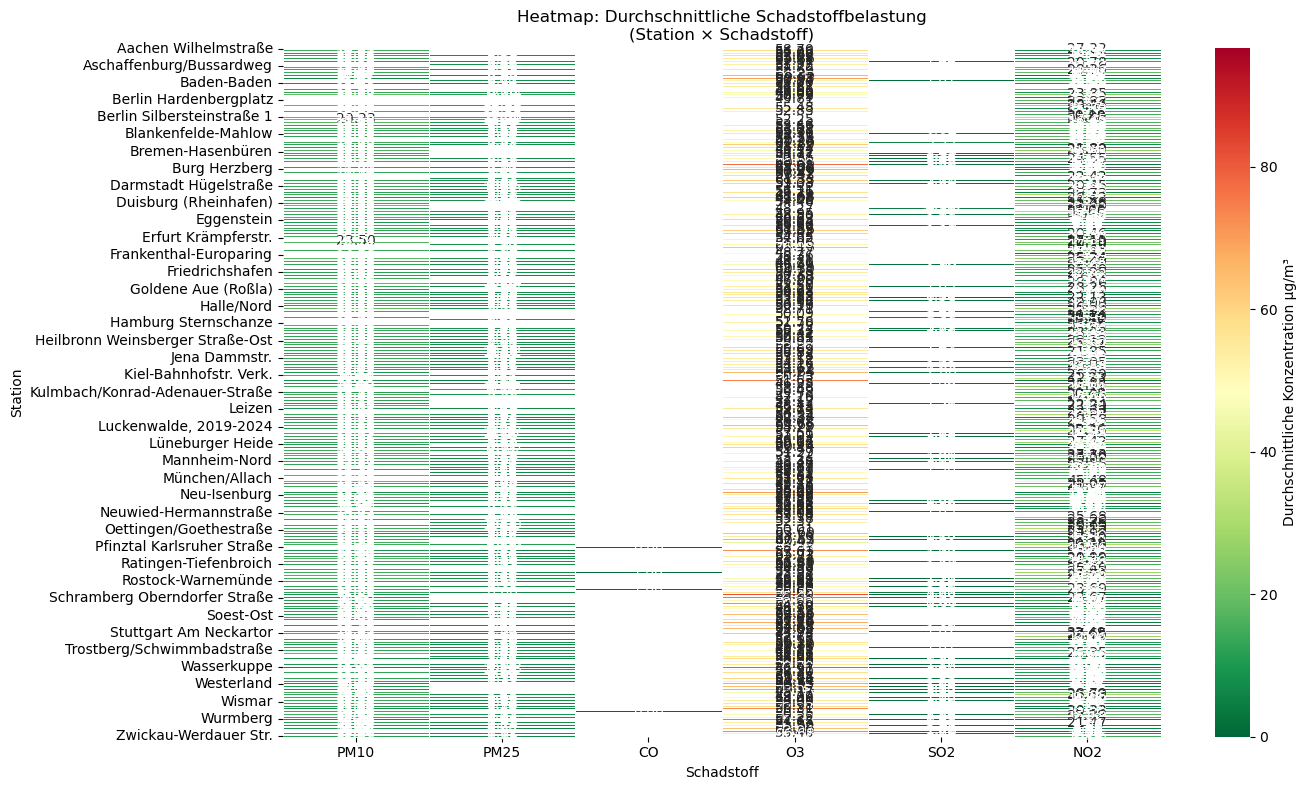


:balkendiagramm: Beispiel: interpolierte Daten (Top 5 Zeilen)
                  Timestamp  PM10  PM25  CO    O3  SO2  NO2
2848582 2023-01-01 01:00:00  59.0   NaN NaN  63.0  NaN  4.0
2848583 2023-01-01 02:00:00   9.0   NaN NaN  61.0  NaN  1.0
2848584 2023-01-01 03:00:00   8.0   NaN NaN  61.0  NaN  2.0
2848585 2023-01-01 04:00:00  13.0   NaN NaN  62.0  NaN  2.0
2848586 2023-01-01 05:00:00  10.0   NaN NaN  64.0  NaN  1.0


In [1]:
import pandas as pd
import os
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
# =========================
# 1. DATEN EINLESEN
# =========================
data_dir = os.path.join(os.getcwd(), 'data', 'raw_data')
li = []
# Prüfen, ob der Ordner existiert
if not os.path.exists(data_dir):
    raise FileNotFoundError(f"Der Ordner '{data_dir}' wurde nicht gefunden.")
for filename in os.listdir(data_dir):
    if filename.endswith(".zip"):
        zip_path = os.path.join(data_dir, filename)
        try:
            with zipfile.ZipFile(zip_path, "r") as z:
                for csv_filename in z.namelist():
                    # FILTER: Ignoriere MacOS Metadaten-Dateien und Ordner
                    if "__MACOSX" in csv_filename or os.path.basename(csv_filename).startswith("._"):
                        continue
                    if csv_filename.endswith(".csv"):
                        try:
                            df_temp = pd.read_csv(
                                z.open(csv_filename),
                                sep=";",
                                decimal=",",
                                encoding="utf-8",
                                low_memory=False # Verhindert DtypeWarnings bei gemischten Typen
                            )
                            li.append(df_temp)
                        except Exception as e:
                            print(f":warnung: Fehler beim Lesen von {csv_filename} in {filename}: {e}")
        except zipfile.BadZipFile:
            print(f":x: Die Datei {filename} ist beschädigt und kann nicht geöffnet werden.")
if not li:
    raise ValueError(":x: Keine gültigen CSV-Daten gefunden!")
df = pd.concat(li, ignore_index=True)
print(f":weißes_häkchen: Daten geladen: {len(df)} Zeilen")
# =========================
# 2. SPALTEN AUFBEREITEN
# =========================
# Spalten umbenennen
# Hinweis: NO2 ist Stickstoffdioxid. NO3 wäre Nitrat. Habe es hier auf NO2 korrigiert.
df = df.rename(columns={
    "Feinstaub (PM₁₀)": "PM10",
    "Feinstaub (PM₂,₅)": "PM25",
    "Kohlenmonoxid (CO)": "CO",
    "Ozon (O₃)": "O3",
    "Schwefeldioxid (SO₂)": "SO2",
    "Stickstoffdioxid (NO₂)": "NO2",
})
pollutants = ["PM10", "PM25", "CO", "O3", "SO2", "NO2"]
# Prüfen, ob alle Spalten vorhanden sind, fehlende Spalten mit NaN auffüllen
for col in pollutants:
    if col not in df.columns:
        df[col] = float("nan")
# In numerische Werte umwandeln
for col in pollutants:
    df[col] = pd.to_numeric(df[col], errors="coerce")
# Timestamp in datetime umwandeln
df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce")
# Zeilen ohne gültigen Timestamp oder Stationscode entfernen, um Fehler beim Sortieren zu vermeiden
df = df.dropna(subset=["Stationscode", "Timestamp"])
# =========================
# 3. SORTIEREN & INTERPOLIEREN
# =========================
# Wichtig für Zeitinterpolation
df = df.sort_values(by=["Stationscode", "Timestamp"])
# Interpolation pro Station
# FIX: Verwendung von 'transform' statt 'apply', um Index-Probleme zu vermeiden
# transform garantiert, dass der Output denselben Index wie der Input hat.
df[pollutants] = (
    df.groupby("Stationscode")[pollutants]
      .transform(lambda x: x.interpolate(method="linear"))
)
# =========================
# 4. HEATMAP VORBEREITEN
# =========================
# Daten für Heatmap aggregieren
heatmap_df = (
    df.groupby("Stationsname")[pollutants]
      .mean()
      .round(2)
)
# Prüfen, ob Daten für die Heatmap vorhanden sind
if heatmap_df.empty:
    print(":warnung: Warnung: Heatmap-DataFrame ist leer. Überprüfe die Daten.")
else:
    # =========================
    # 5. HEATMAP VISUALISIEREN
    # =========================
    plt.figure(figsize=(14, 8))
    sns.heatmap(
        heatmap_df,
        cmap="RdYlGn_r", # Rot für hoch (schlecht), Grün für niedrig (gut)
        annot=True,
        fmt=".2f",
        linewidths=0.5,
        cbar_kws={"label": "Durchschnittliche Konzentration µg/m³"}
    )
    plt.title("Heatmap: Durchschnittliche Schadstoffbelastung\n(Station × Schadstoff)")
    plt.xlabel("Schadstoff")
    plt.ylabel("Station")
    plt.tight_layout()
    plt.show()
# =========================
# 6. OPTIONAL: KONTROLLAUSGABE
# =========================
print("\n:balkendiagramm: Beispiel: interpolierte Daten (Top 5 Zeilen)")
# Nur Zeilen anzeigen, wenn die Station existiert
beispiel_station = "Aachen-Burtscheid"
if beispiel_station in df["Stationsname"].values:
    print(df[df["Stationsname"] == beispiel_station][["Timestamp"] + pollutants].head())
else:
    print(f"Station '{beispiel_station}' nicht in den Daten gefunden. Zeige erste 5 Zeilen allgemein:")
    print(df[["Stationsname", "Timestamp"] + pollutants].head())

In [6]:
import pandas as pd
import os
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
# =========================
# 1. DATEN EINLESEN
# =========================
data_dir = os.path.join(os.getcwd(), 'data', 'raw_data')
li = []
# Prüfen, ob der Ordner existiert
if not os.path.exists(data_dir):
    raise FileNotFoundError(f"Der Ordner '{data_dir}' wurde nicht gefunden.")
for filename in os.listdir(data_dir):
    if filename.endswith(".zip"):
        zip_path = os.path.join(data_dir, filename)
        try:
            with zipfile.ZipFile(zip_path, "r") as z:
                for csv_filename in z.namelist():
                    # FILTER: Ignoriere MacOS Metadaten-Dateien und Ordner
                    if "__MACOSX" in csv_filename or os.path.basename(csv_filename).startswith("._"):
                        continue
                    if csv_filename.endswith(".csv"):
                        try:
                            df_temp = pd.read_csv(
                                z.open(csv_filename),
                                sep=";",
                                decimal=",",
                                encoding="utf-8",
                                low_memory=False # Verhindert DtypeWarnings bei gemischten Typen
                            )
                            li.append(df_temp)
                        except Exception as e:
                            print(f":warnung: Fehler beim Lesen von {csv_filename} in {filename}: {e}")
        except zipfile.BadZipFile:
            print(f":x: Die Datei {filename} ist beschädigt und kann nicht geöffnet werden.")
if not li:
    raise ValueError(":x: Keine gültigen CSV-Daten gefunden!")
df = pd.concat(li, ignore_index=True)
print(f":weißes_häkchen: Daten geladen: {len(df)} Zeilen")

:weißes_häkchen: Daten geladen: 4422469 Zeilen


In [7]:
# =========================
# 2. SPALTEN AUFBEREITEN
# =========================
# Spalten umbenennen
# Hinweis: NO2 ist Stickstoffdioxid. NO3 wäre Nitrat. Habe es hier auf NO2 korrigiert.
df = df.rename(columns={
    "Feinstaub (PM₁₀)": "PM10",
    "Feinstaub (PM₂,₅)": "PM25",
    "Kohlenmonoxid (CO)": "CO",
    "Ozon (O₃)": "O3",
    "Schwefeldioxid (SO₂)": "SO2",
    "Stickstoffdioxid (NO₂)": "NO2",
})
pollutants = ["PM10", "PM25", "CO", "O3", "SO2", "NO2"]
# Prüfen, ob alle Spalten vorhanden sind, fehlende Spalten mit NaN auffüllen
for col in pollutants:
    if col not in df.columns:
        df[col] = float("nan")
# In numerische Werte umwandeln
for col in pollutants:
    df[col] = pd.to_numeric(df[col], errors="coerce")
# Timestamp in datetime umwandeln
df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce")
# Zeilen ohne gültigen Timestamp oder Stationscode entfernen, um Fehler beim Sortieren zu vermeiden
df = df.dropna(subset=["Stationscode", "Timestamp"])

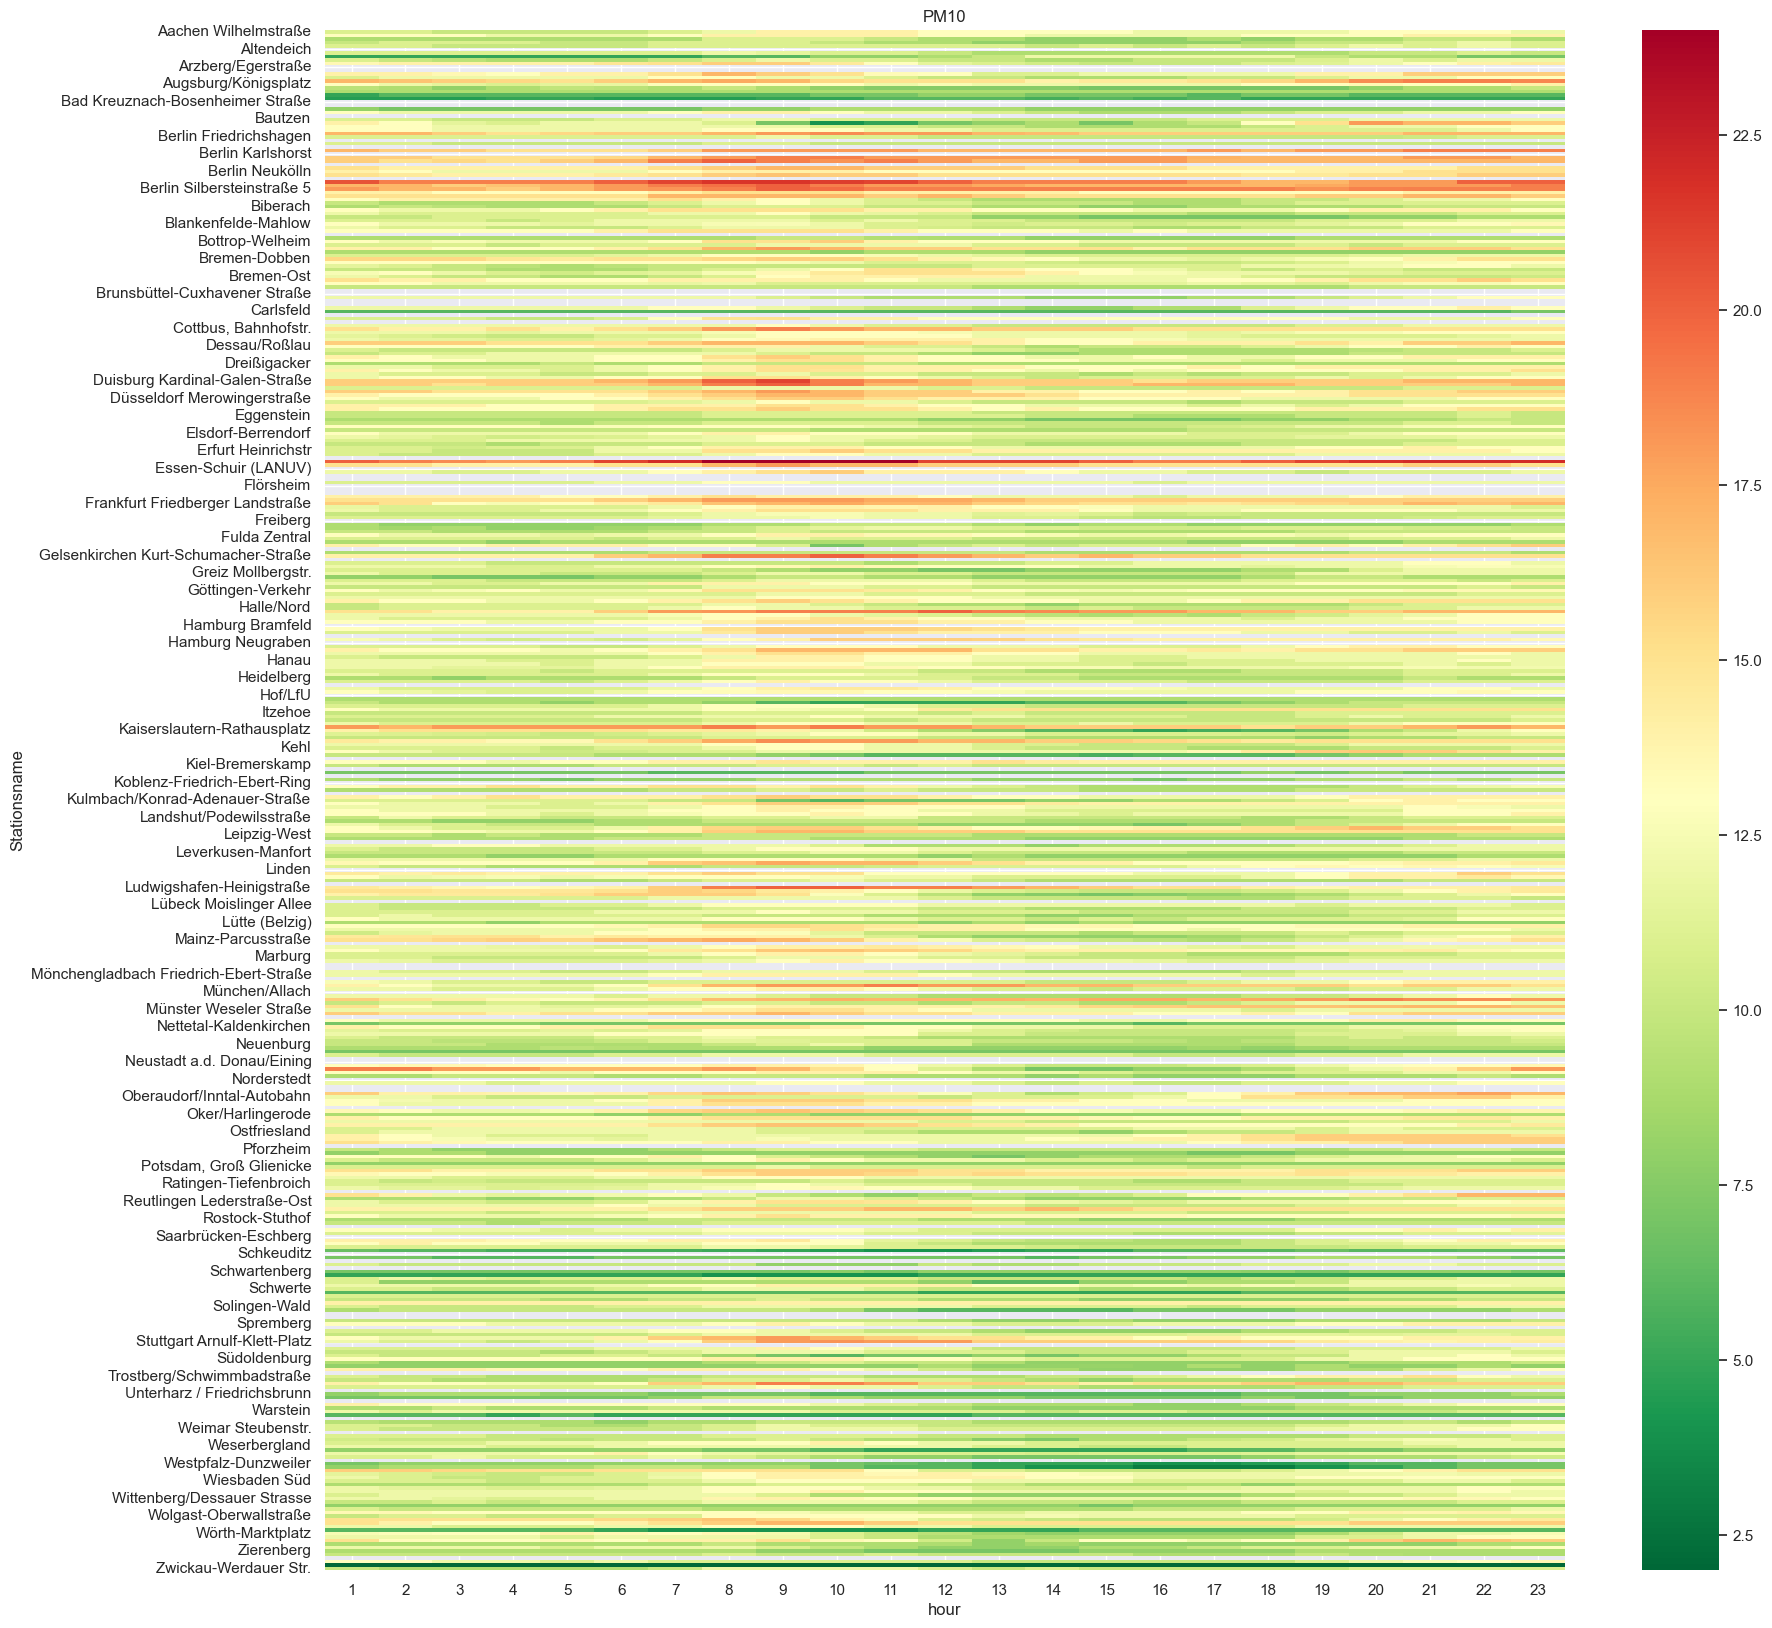

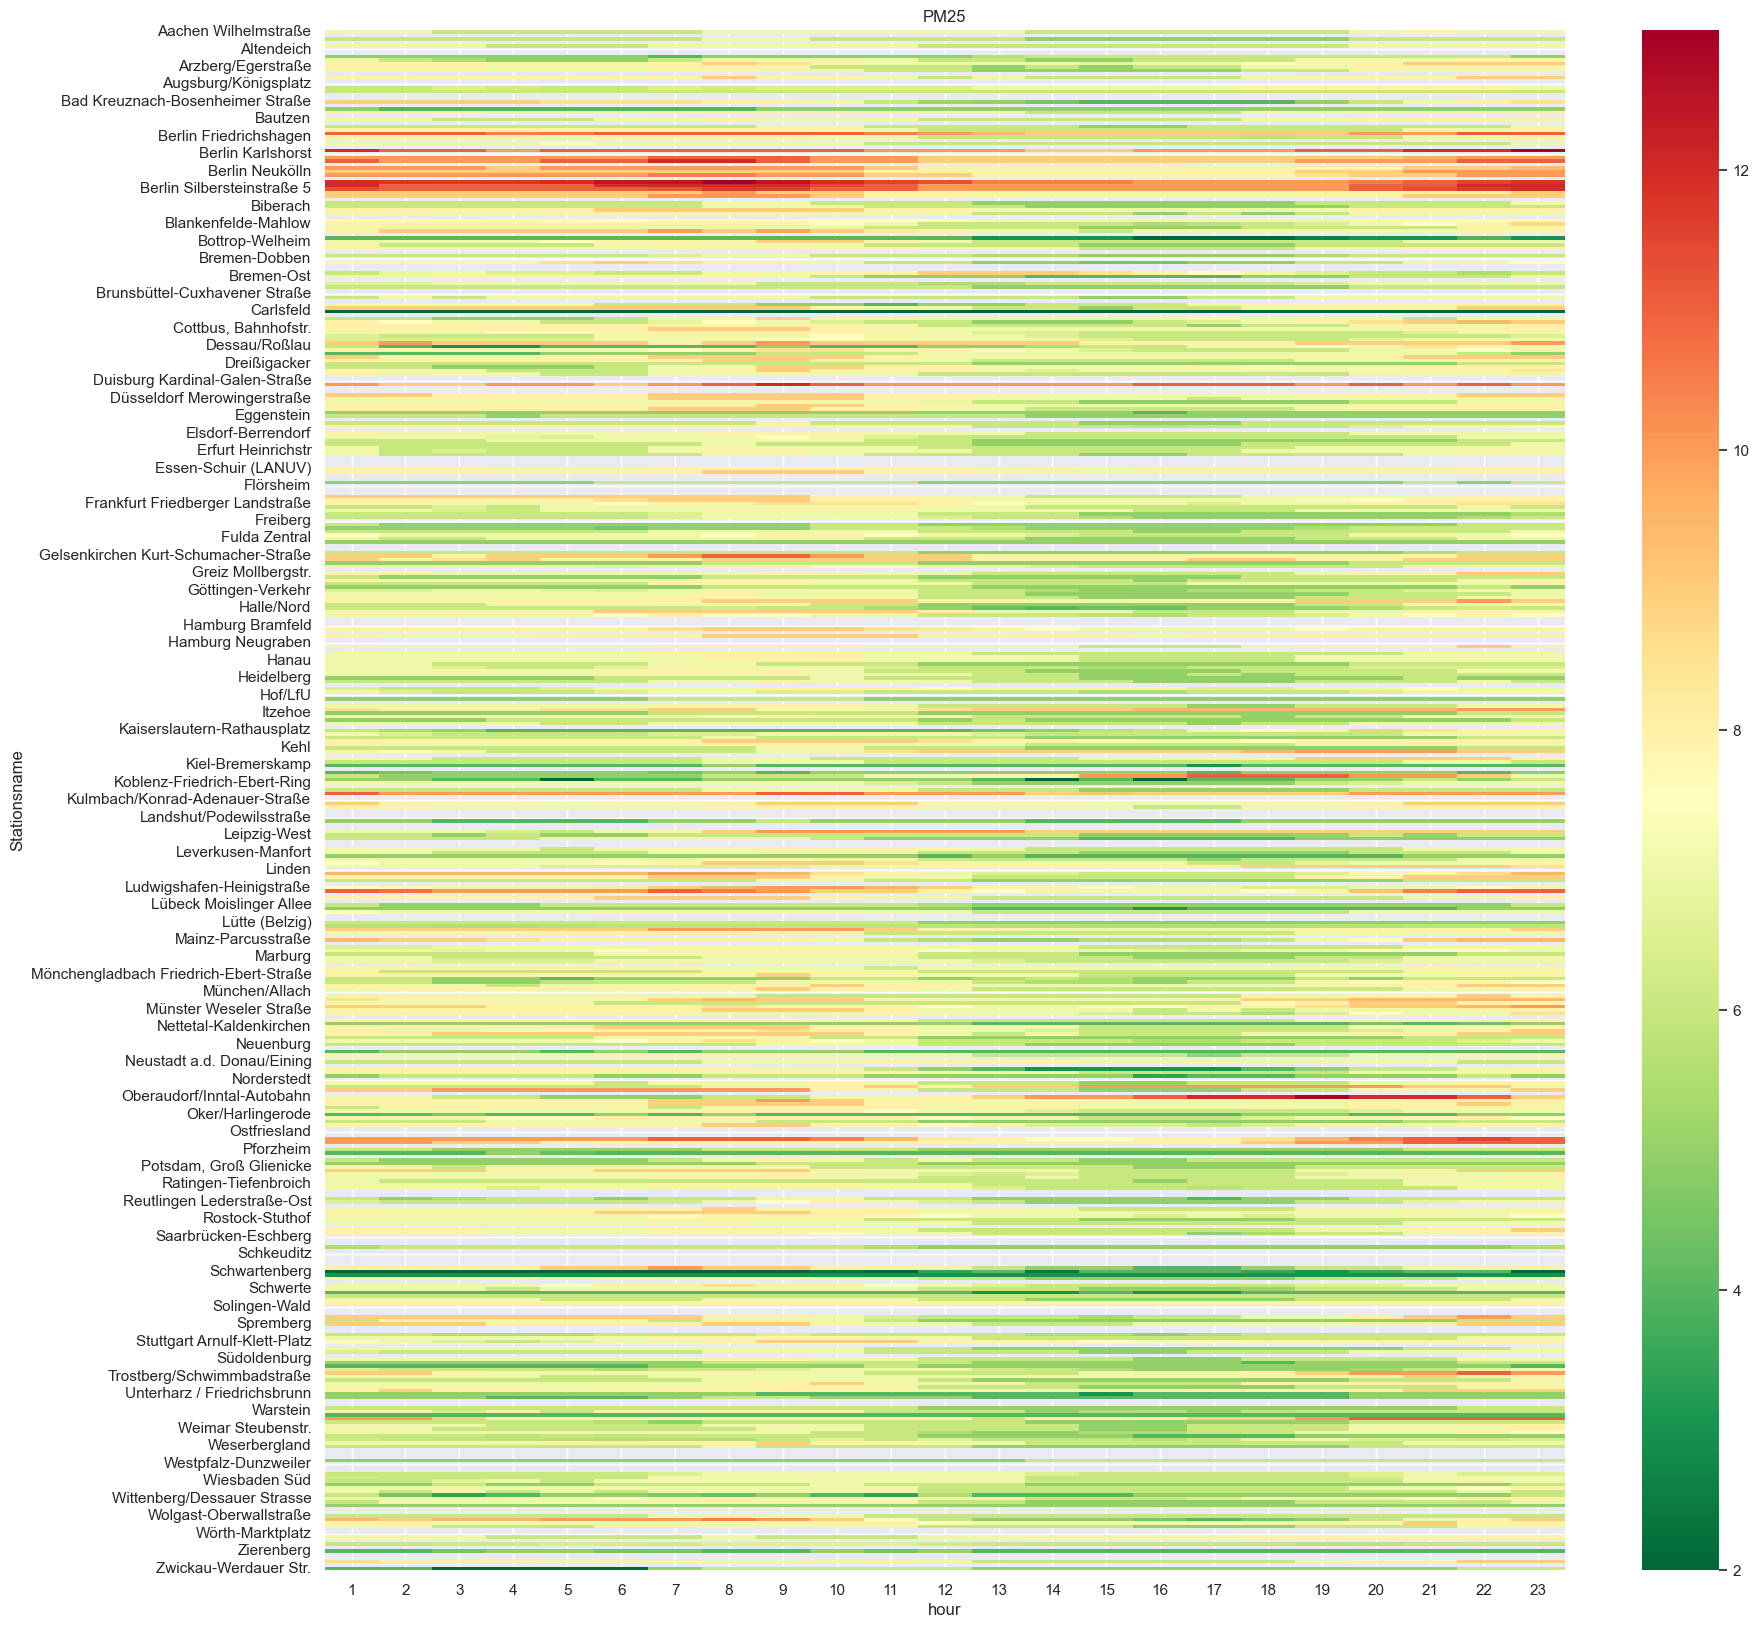

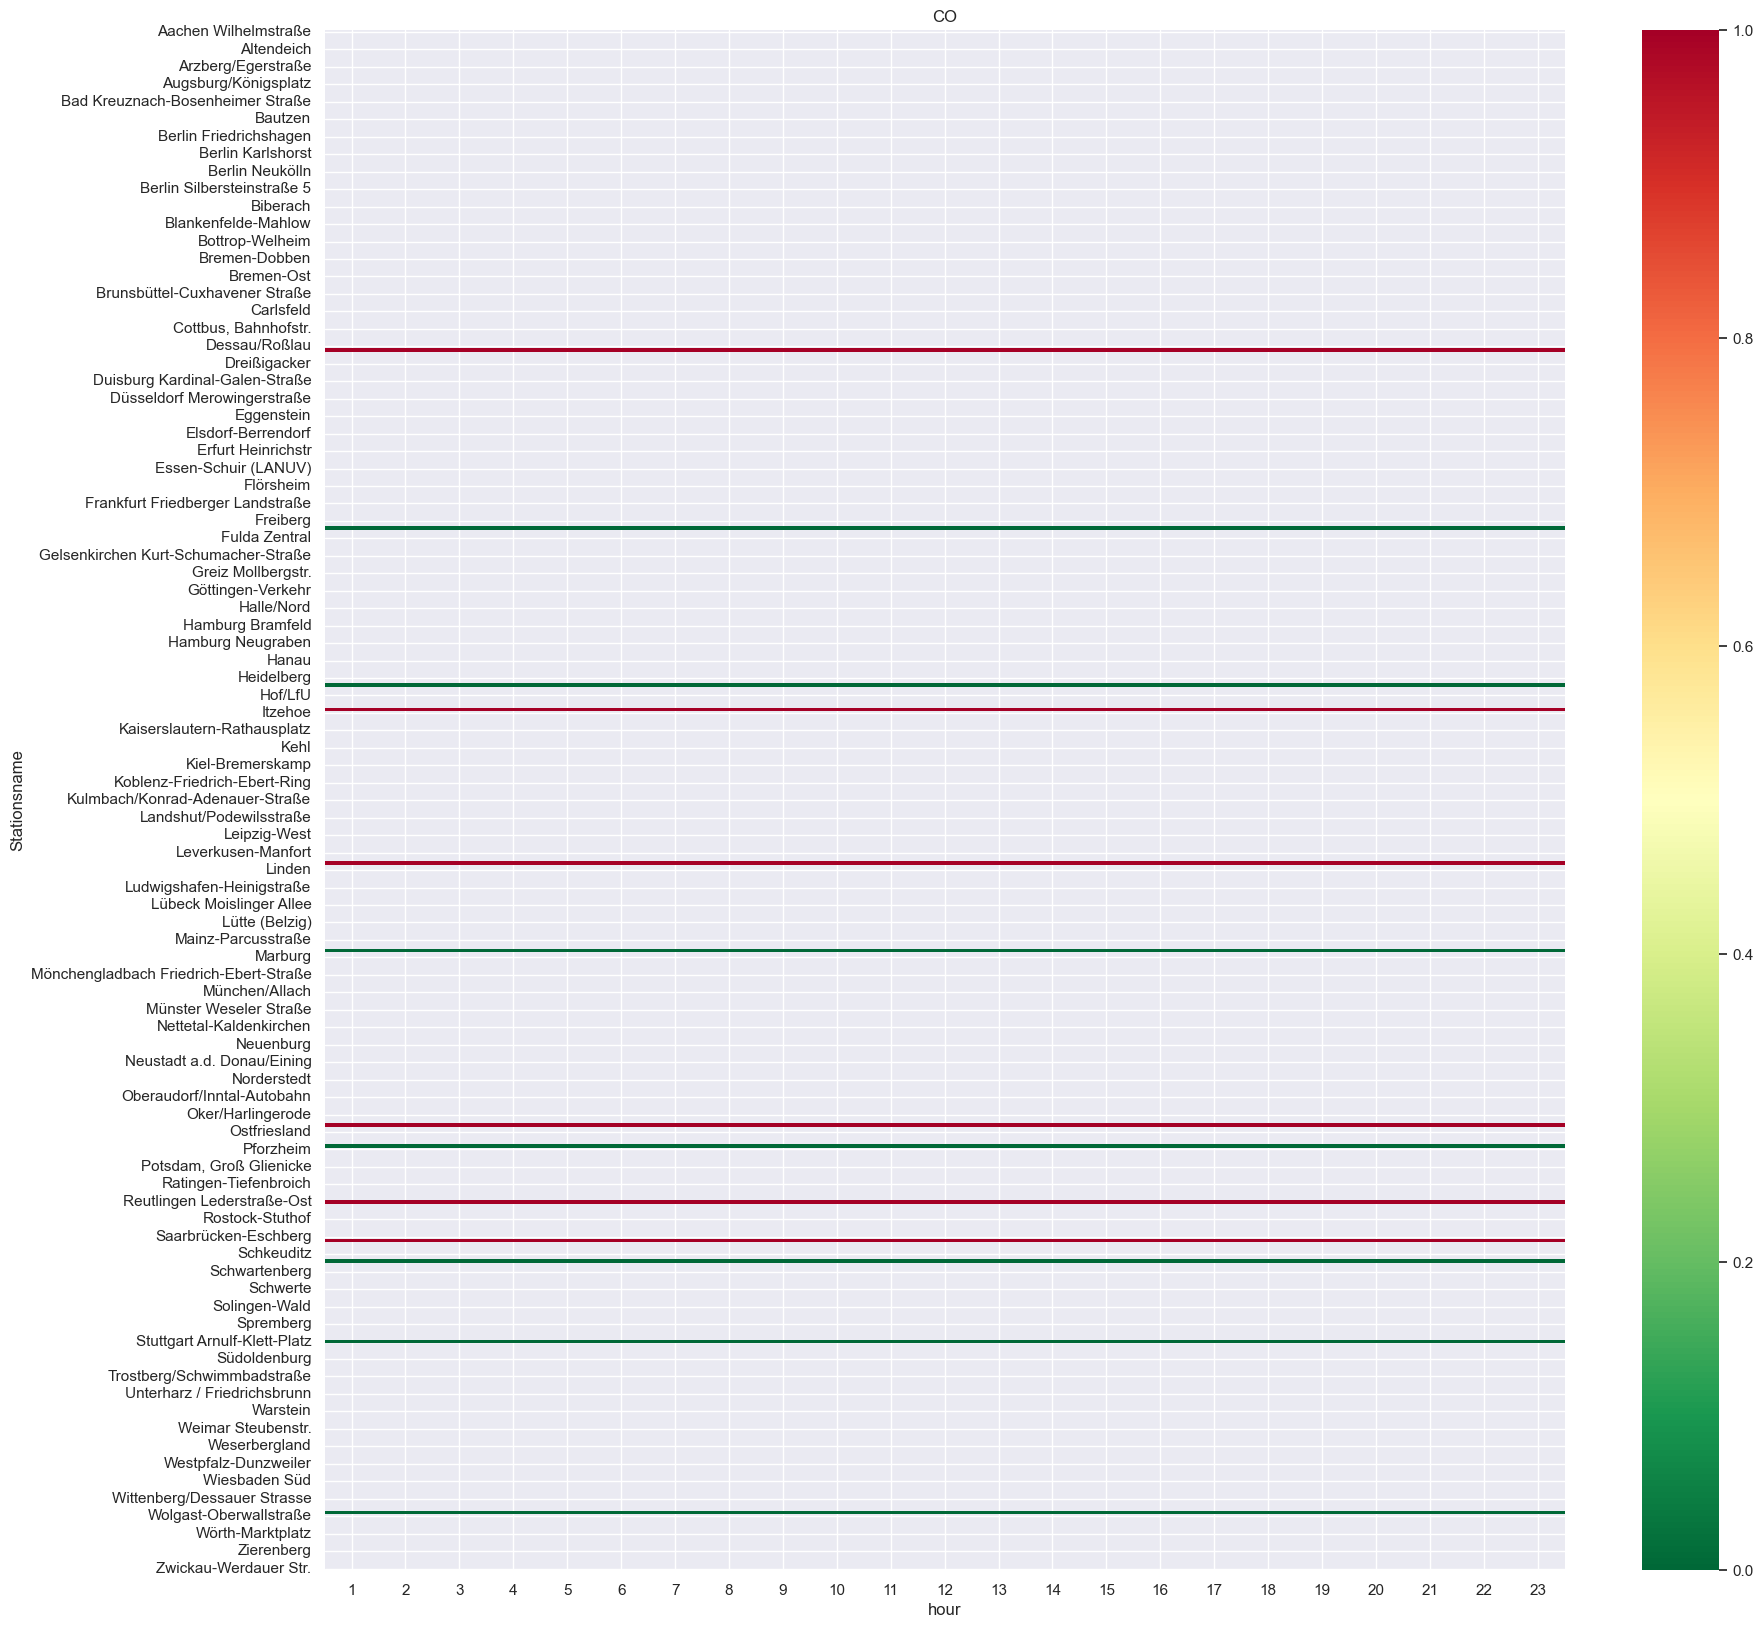

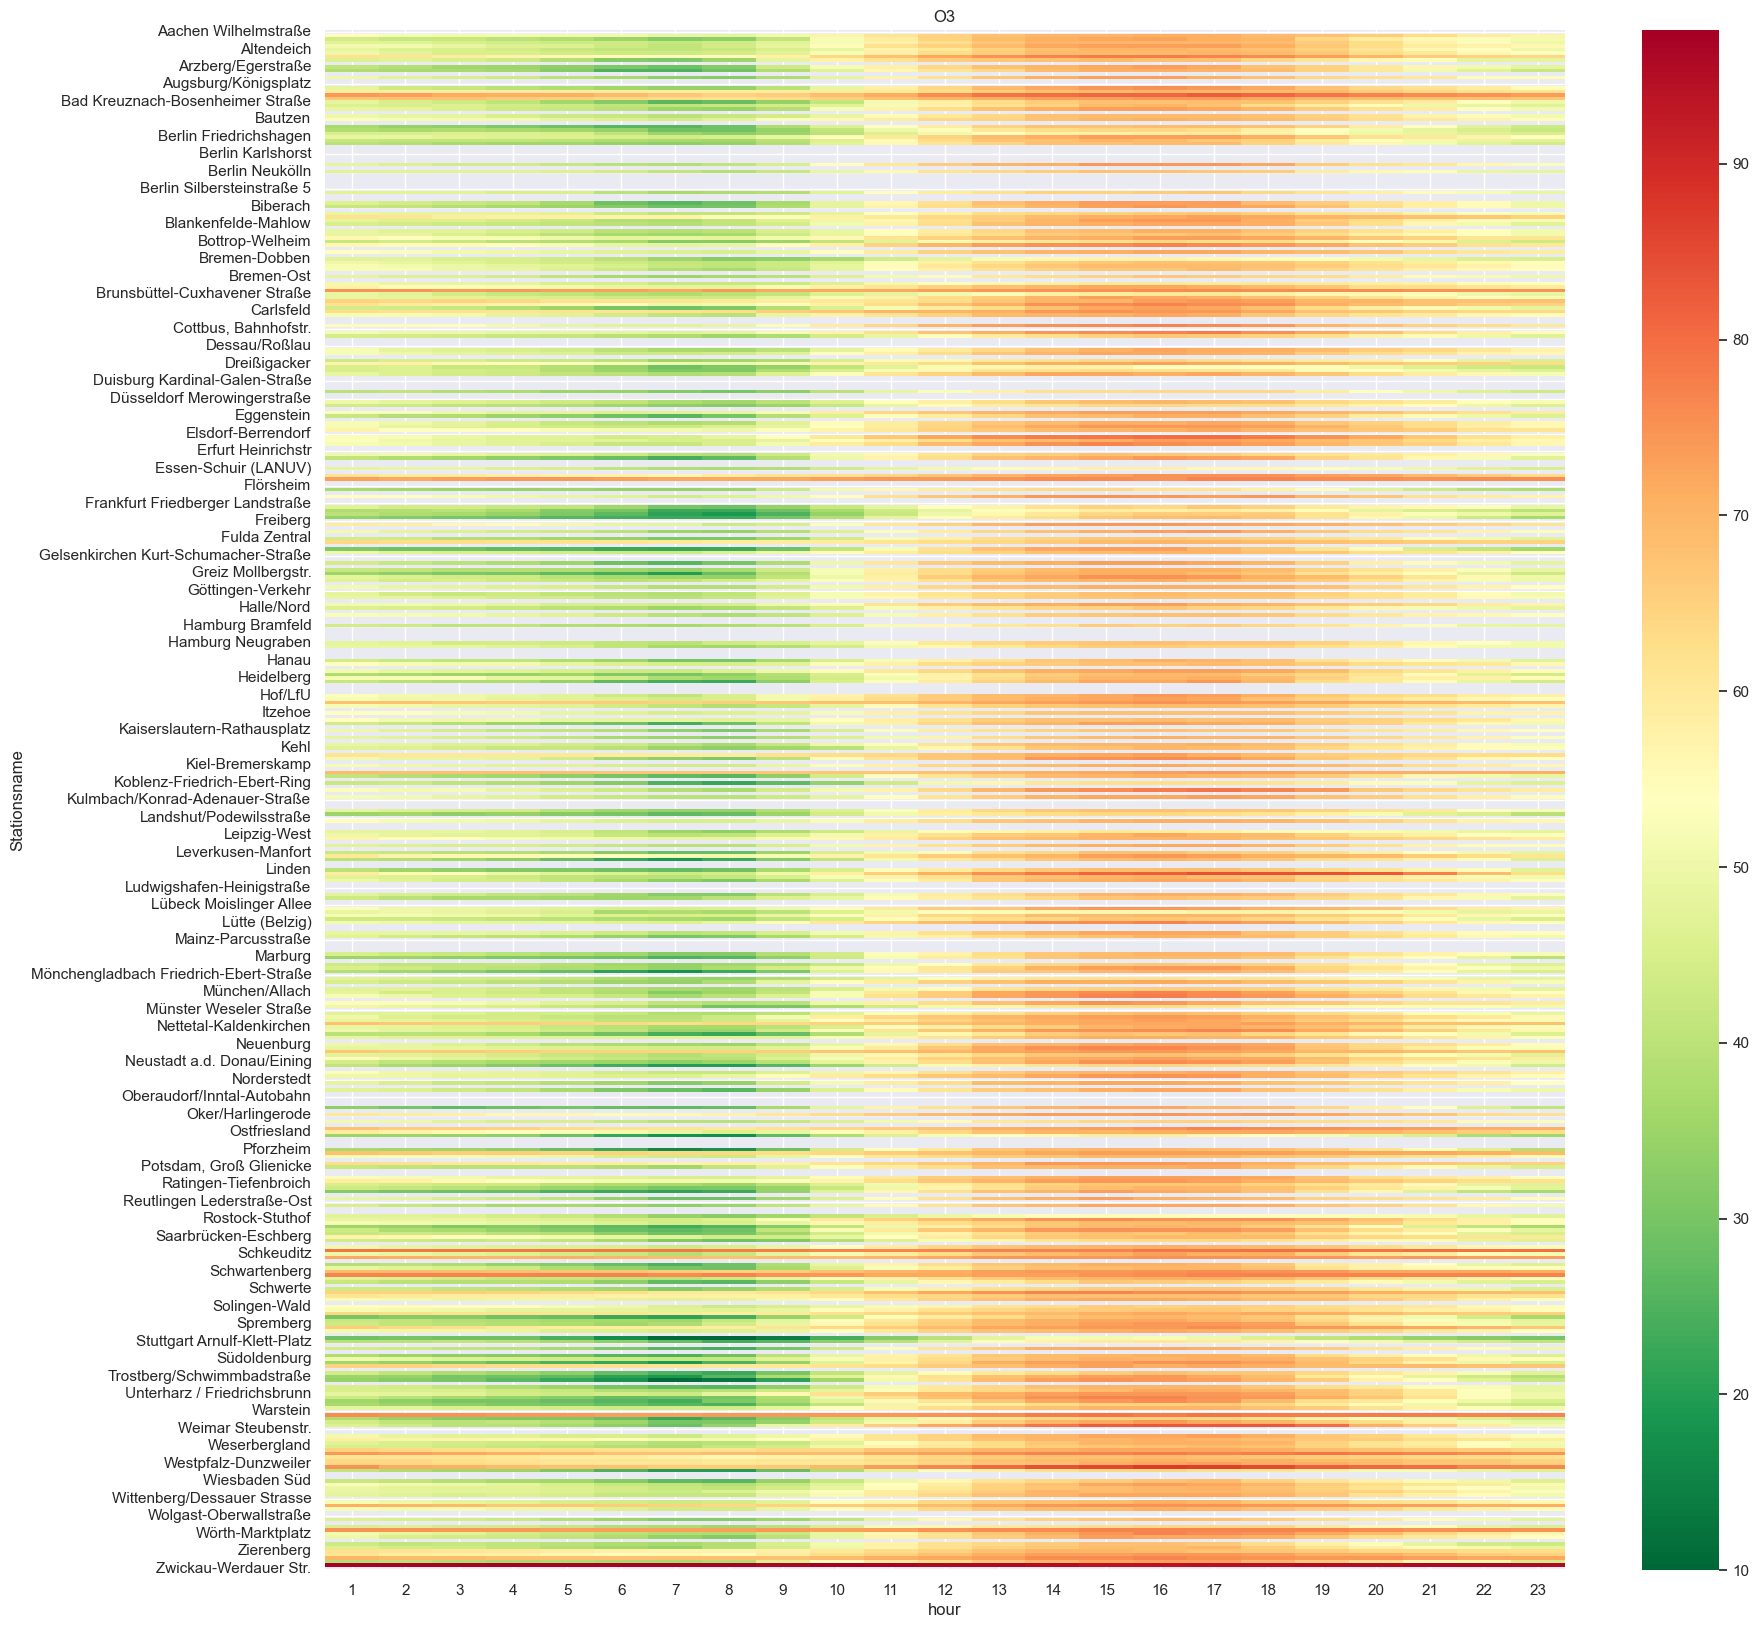

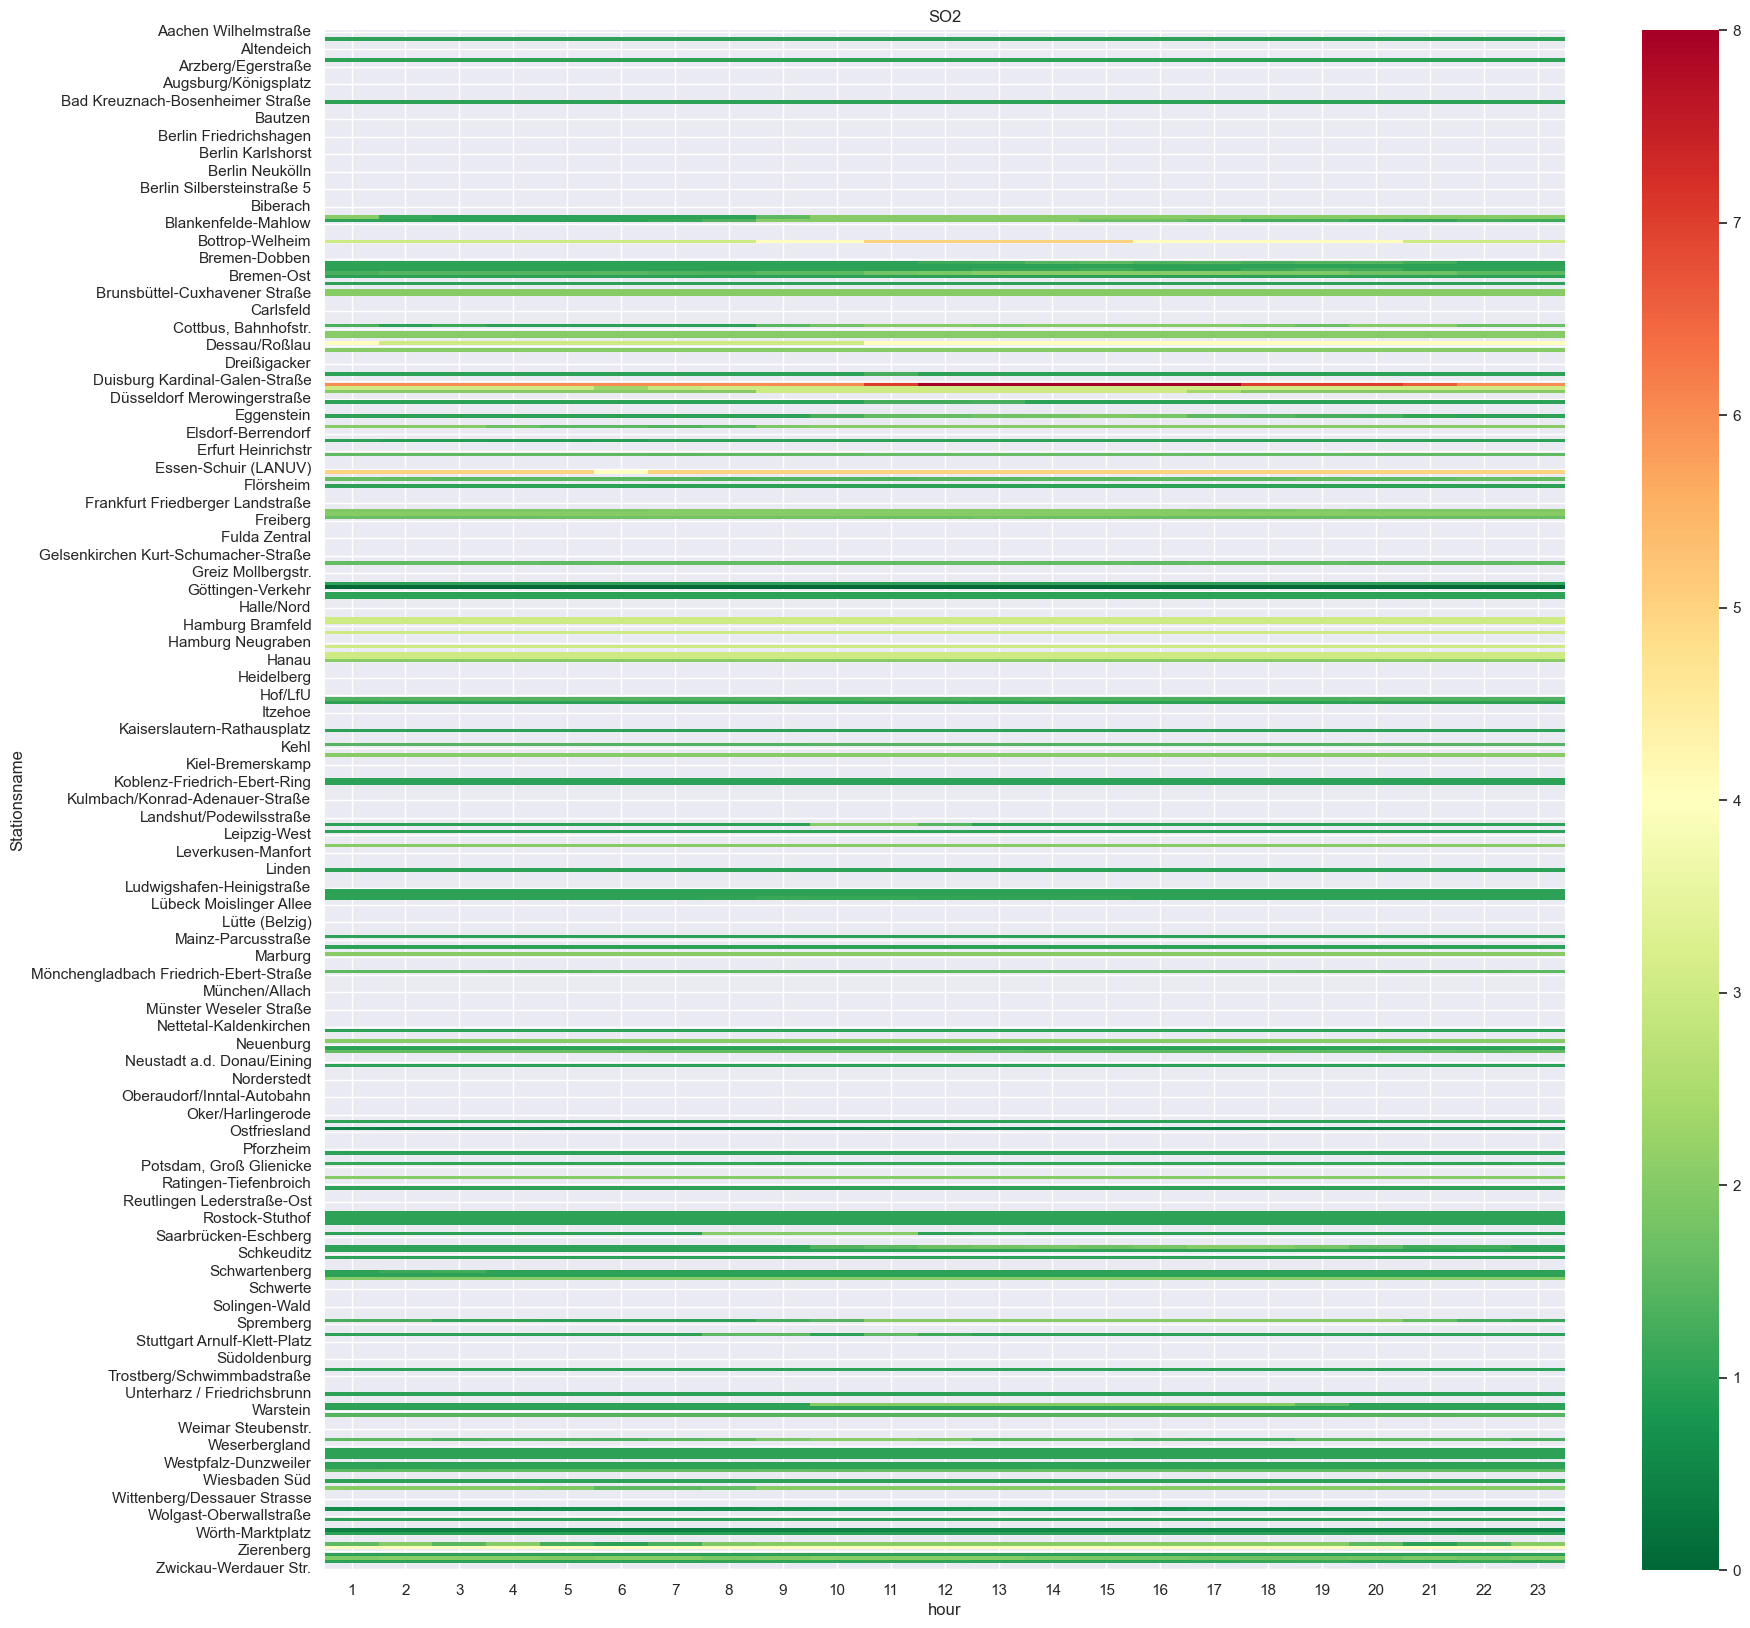

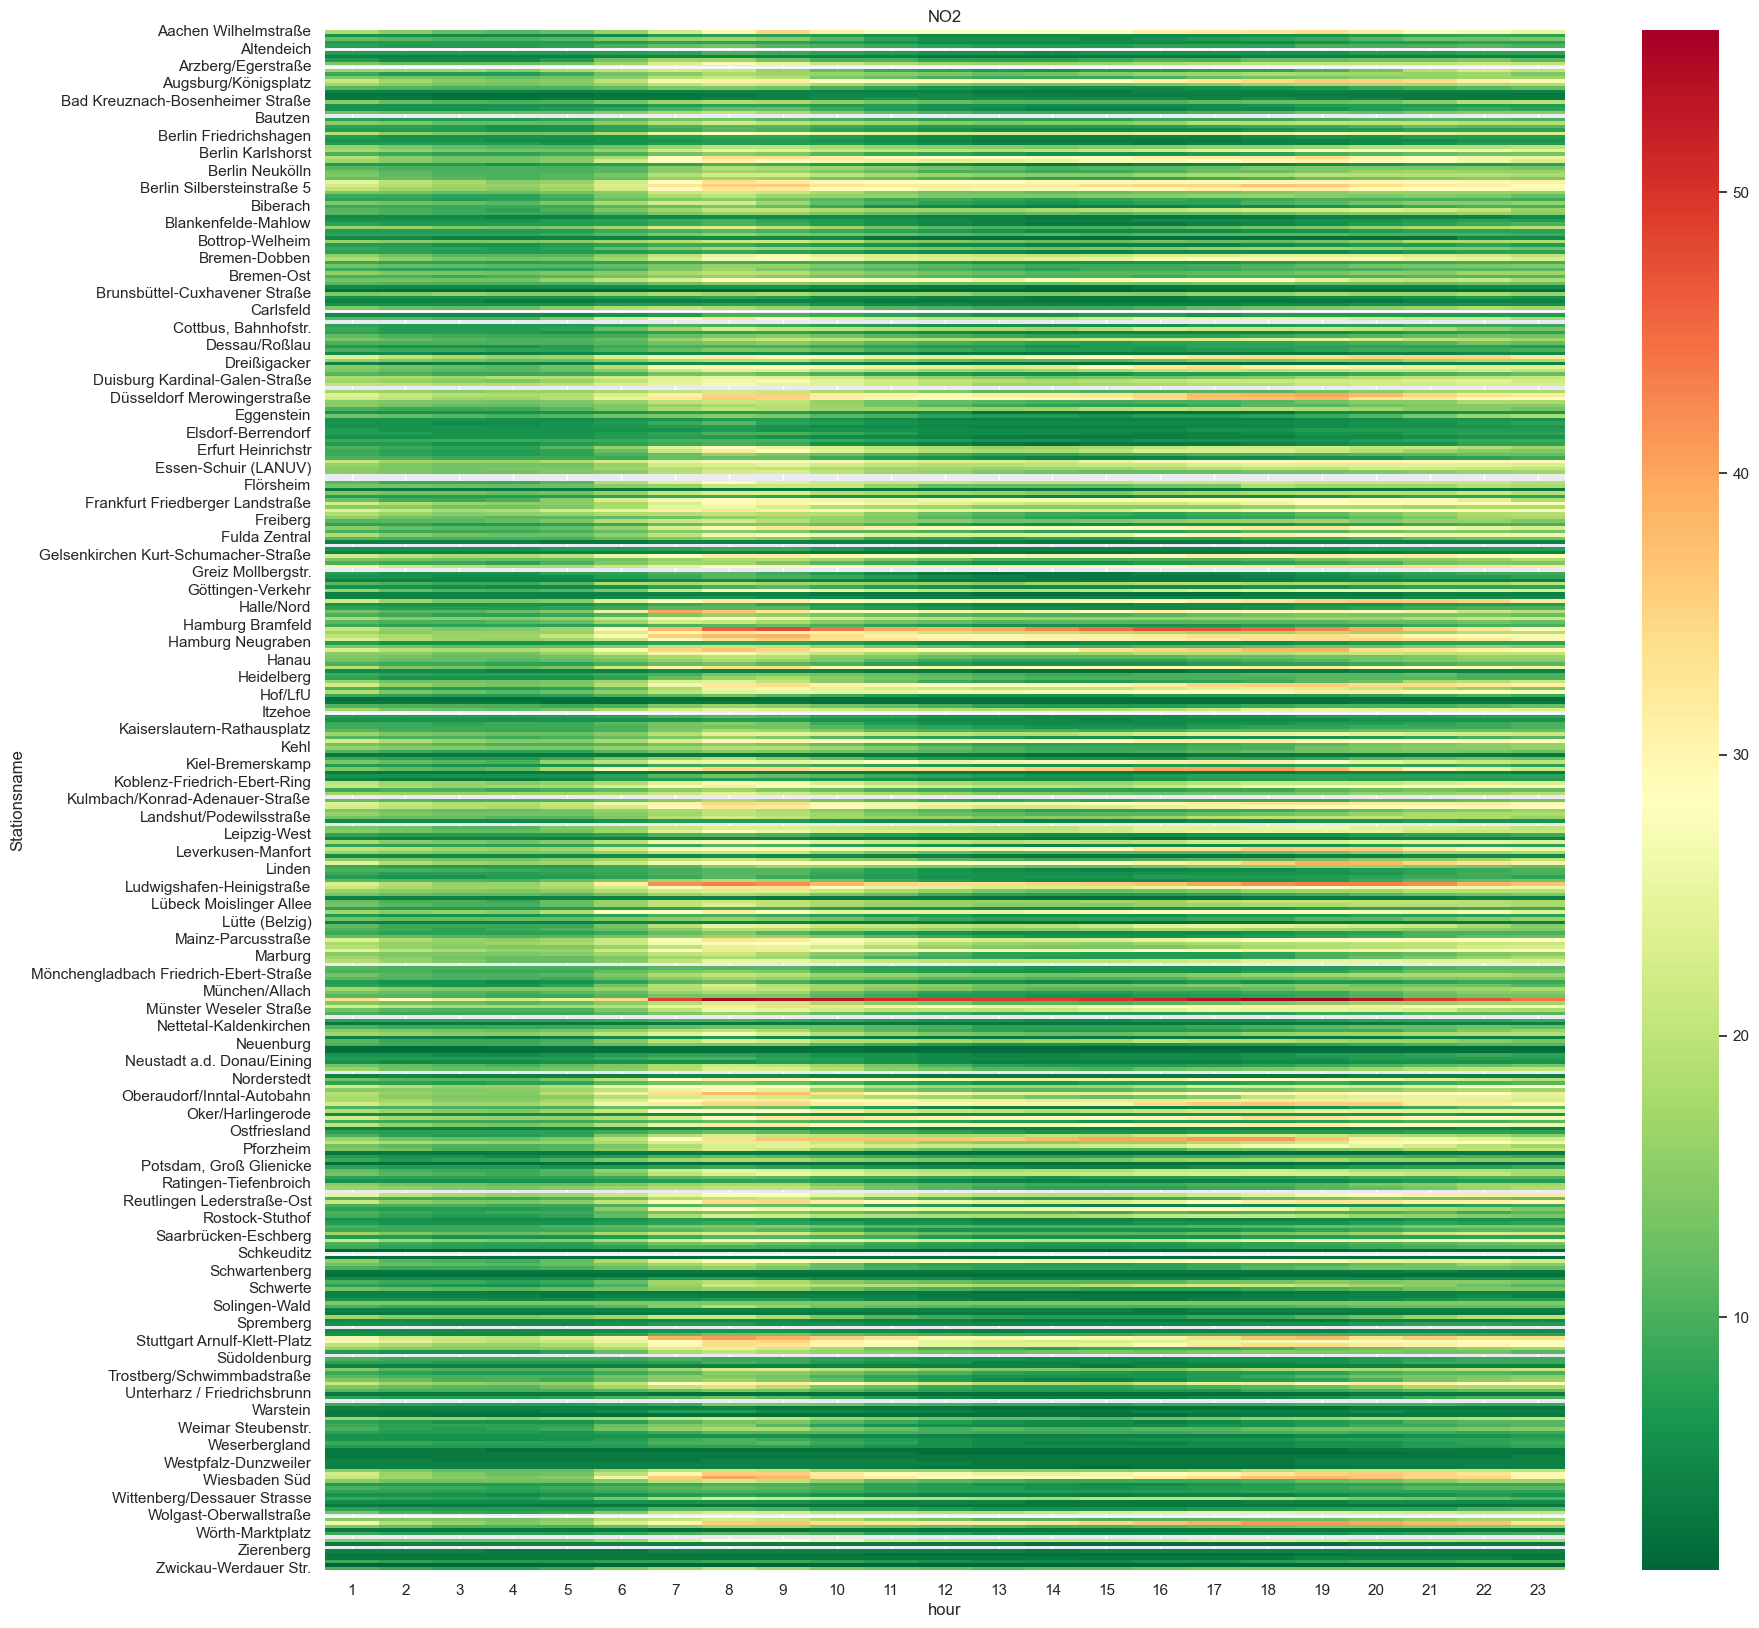

In [29]:
sns.set_theme()

agg_data= df.groupby(['Stationsname', 'hour'])[pollutants].median().reset_index()

for i,col in enumerate(pollutants):

    fig, ax = plt.subplots(figsize=(20,20))
    heatmap_data = agg_data.pivot(index='Stationsname', columns='hour', values=col)
    ax.set_title(col)
    sns.heatmap(
        heatmap_data ,
        ax=ax,
        cmap="RdYlGn_r",
    )

In [10]:
# 3. SORTIEREN & INTERPOLIEREN
# =========================
# Wichtig für Zeitinterpolation
df = df.sort_values(by=["Stationscode", "Timestamp"])
# Interpolation pro Station
# FIX: Verwendung von 'transform' statt 'apply', um Index-Probleme zu vermeiden
# transform garantiert, dass der Output denselben Index wie der Input hat.
df['hour']= df['Timestamp'].dt.hour
df[pollutants] = (
    df.groupby(["Stationscode", "hour"])[pollutants]
      .transform(lambda x: x.fillna(x.median()))
)

In [11]:
df.head()

,Stationscode,Stationsname,Stationsumgebung,Art der Station,Timestamp,Einheit,PM10,PM25,CO,O3,SO2,NO2,hour
0,DEBB021,Potsdam-Zentrum,städtisches Gebiet,Hintergrund,2023-01-01 01:00:00,µg/m³,12.0,7.0,NaN,54.0,4.0,8.0,1
1,DEBB021,Potsdam-Zentrum,städtisches Gebiet,Hintergrund,2023-01-01 02:00:00,µg/m³,12.0,7.0,NaN,59.0,2.0,4.0,2
2,DEBB021,Potsdam-Zentrum,städtisches Gebiet,Hintergrund,2023-01-01 03:00:00,µg/m³,11.0,7.0,NaN,59.0,1.0,4.0,3
3,DEBB021,Potsdam-Zentrum,städtisches Gebiet,Hintergrund,2023-01-01 04:00:00,µg/m³,11.0,7.0,NaN,60.0,1.0,4.0,4
4,DEBB021,Potsdam-Zentrum,städtisches Gebiet,Hintergrund,2023-01-01 05:00:00,µg/m³,11.0,7.0,NaN,61.0,1.0,4.0,5


In [ ]:
# 4. HEATMAP VORBEREITEN
# =========================
# Daten für Heatmap aggregieren
heatmap_df = (
    df.groupby("Stationsname")[pollutants]
      .mean()
      .round(2)
)
# Prüfen, ob Daten für die Heatmap vorhanden sind
if heatmap_df.empty:
    print(":warnung: Warnung: Heatmap-DataFrame ist leer. Überprüfe die Daten.")
else:

In [ ]:
 # =========================
    # 5. HEATMAP VISUALISIEREN
    # =========================
    plt.figure(figsize=(14, 8))
    sns.heatmap(
        heatmap_df,
        cmap="RdYlGn_r", # Rot für hoch (schlecht), Grün für niedrig (gut)
        annot=True,
        fmt=".2f",
        linewidths=0.5,
        cbar_kws={"label": "Durchschnittliche Konzentration µg/m³"}
    )
    plt.title("Heatmap: Durchschnittliche Schadstoffbelastung\n(Station × Schadstoff)")
    plt.xlabel("Schadstoff")
    plt.ylabel("Station")
    plt.tight_layout()
    plt.show()

In [ ]:

# 6. OPTIONAL: KONTROLLAUSGABE
# =========================
print("\n:balkendiagramm: Beispiel: interpolierte Daten (Top 5 Zeilen)")
# Nur Zeilen anzeigen, wenn die Station existiert
beispiel_station = "Aachen-Burtscheid"
if beispiel_station in df["Stationsname"].values:
    print(df[df["Stationsname"] == beispiel_station][["Timestamp"] + pollutants].head())
else:
    print(f"Station '{beispiel_station}' nicht in den Daten gefunden. Zeige erste 5 Zeilen allgemein:")
    print(df[["Stationsname", "Timestamp"] + pollutants].head())